<a href="https://colab.research.google.com/github/FabioMMaia/face_recognition_4models/blob/main/Modeling_HOG_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import cv2
from PIL import Image
from skimage import data, exposure
from skimage.feature import hog,local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from numpy.random import seed
import pickle
from tqdm import tqdm

import pytz
from datetime import datetime
from collections import Counter
import math

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

In [3]:
!pip install unidecode

def norm_text(txt):
  from unidecode import unidecode
  return unidecode(txt).replace(' ','_').lower()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 10.9 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
config_dir = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/config/'
model_save_dir = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/model/'
erro_dir = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/error/'
log_dir = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/log/'

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Modelos_Implementações')

In [7]:
import MLP as mlp # multilayer perceptron
import Multinomial_LogReg # regressão logística com alpha variavel (bissecao)
import R_LOG as r_log # regressão logística com alpha fixo
import SVM_OVR # SVM one-versus-rest
import ANN

In [8]:
# import importlib

# importlib.reload(ANN)
# importlib.reload(mlp)
# importlib.reload(Multinomial_LogReg)
# importlib.reload(r_log)
# importlib.reload(SVM_OVR)
# importlib.reload(ANN)

In [9]:
class logfile():

  def __init__(self, diretorio):
    self.diretorio=diretorio

  def start(self, tag, use_dateref=True):
    if use_dateref:
      tag = tag + '_' + datetime.now(pytz.timezone('America/Bahia')).strftime("%Y%m%d")
    self.save_file = open(self.diretorio +  tag + '.txt', 'w')
    data_atual = datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")
    print('Execução em:', data_atual, file=self.save_file)
    
  def end(self):
    data_atual = datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")
    print('Fim de Execução em:', data_atual, file=self.save_file)
    self.save_file.close()

In [10]:
# Visualize Dataset

In [11]:
def generate_image_db(keep_images):
  import zipfile
  from skimage.transform import resize


  imagens_path = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/CelebA/img_align_celeba.zip'
  imgzip = zipfile.ZipFile(imagens_path)
  inflist = imgzip.infolist()
  all_images = {}

  for f in tqdm(inflist):
    file_name = f.filename.split('/')[1]
    if file_name in keep_images:
      if '.jpg' in file_name:
        ifile = imgzip.open(f)
        img = Image.open(ifile)
        img_resize = resize(np.array(img), (128, 128))
        all_images[file_name] = [img_resize]

  return all_images

def plt_samples(imgs):
  # faces que foram reconhecidas pelo viola jones
  fig, axes = plt.subplots(1,5, figsize=(10,10))

  imgs= pd.DataFrame(imgs)

  for (i,row), ax in zip(imgs.head(8).iterrows(), axes.ravel()): 
    ax.axis('off')
    ax.imshow(row[0], cmap=plt.cm.gray)

def visualize_5photos(y):
  amostra= generate_image_db(y.sample(5).index)
  amostra_df = pd.DataFrame(amostra).T.reset_index()
  plt_samples(amostra_df)

# Carregando Dataset - HOG

In [13]:
n_classes=50
ref = 'HOG' 
tag= 'hog' + '_'+ str(n_classes) + '_classes'

with open(r'/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Data/X_y_' + tag +'.obj', "rb") as f:
    X,y = pickle.load(f)

100%|██████████| 202600/202600 [00:03<00:00, 51219.79it/s]


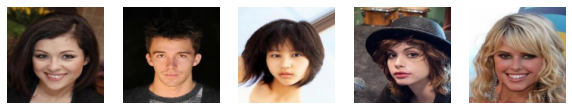

In [14]:
visualize_5photos(y)

In [15]:
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (1443, 4608)
y shape: (1443,)


In [16]:
# transformar categorias em one-hot-encoding: Saída
saida = y.max()+1
print("Quantidade de pessoas:",saida)
target = keras.utils.to_categorical(y, saida)

Quantidade de pessoas: 50


# Train x Test

In [17]:
def train_test_separation(X, y):

  n_classes = len(np.unique(y))

  x_train, x_test, y_train_n, y_test_n = train_test_split(X, y, test_size=0.30, random_state=42,stratify=y)

  y_train = keras.utils.to_categorical(y_train_n.values, n_classes)
  y_test = keras.utils.to_categorical(y_test_n.values, n_classes)

  assert y_train.shape[0]== y_train_n.shape[0]
  assert y_test.shape[0]== y_test_n.shape[0]

  print('x_train shape:', x_train.shape,'y_train shape:',  y_train_n.shape, 'y_train (ohe) shape:' ,y_train.shape, 'x_test shape:',  x_test.shape,'y_test shape:', y_test_n.shape,'y_test (ohe) shape:', y_test.shape)

  return x_train, y_train_n, y_train, x_test, y_test, y_test_n

In [18]:
def apply_PCA(n_pca, x_train,x_test):
  pca = PCA(n_components=n_pca, random_state=42)
  pca.fit(x_train)

  print('variancia explicada:', sum(pca.explained_variance_ratio_))
  x_train_pca = pca.transform(x_train)
  x_test_pca = pca.transform(x_test)

  x_train_pca_norm = (x_train_pca - x_train_pca.mean(axis=0))/  x_train_pca.std(axis=0)
  x_test_pca_norm = (x_test_pca - x_train_pca.mean(axis=0))/  x_train_pca.std(axis=0)

  return x_train_pca_norm, x_test_pca_norm

In [19]:
X_train, y_train_n, y_train, X_test, y_test, y_test_n = train_test_separation(X,y)

x_train shape: (1010, 4608) y_train shape: (1010,) y_train (ohe) shape: (1010, 50) x_test shape: (433, 4608) y_test shape: (433,) y_test (ohe) shape: (433, 50)


In [20]:
X_train_pca, X_test_pca = apply_PCA(n_pca=50, x_train=X_train, x_test=X_test)

variancia explicada: 0.3745356758641867


In [21]:
def unpack_dict_as_str(dicionario):
  string=''

  for k,v in dicionario.items():
    string= string + str(k) + ':[ '
    try:
      for v_ in v:
        string= string + str(v_) + ' '
      string= string+'] '
    except:
      string= string + str(v) + '] '
  return string.strip()

# unpack_dict_as_str({'a':[2,5,6], 'b':[6,7]})

In [26]:
def pipeline_integrated_onedim(nome_do_modelo, #nome do modelo
                               classifier, # classificador
                               param_iteracao, # parametro iteração - deve conter um dicionario com a lista de valores a ser iterado
                               param_fixo,  # parametro fixo e respectivo valor (uma lista)
                               data, # dicionario de treino e teste
                               kf= KFold(n_splits=5, shuffle=True, random_state=42),
                               neural_network=False): #kfold

  print('Pipeline de testes para o modelo:', nome_do_modelo)
  X_train = data['X_train']
  X_test = data['X_test']
  y_train = data['y_train']
  y_test = data['y_test']

  log={}
  log['exec_time'] = 'Execução em: {}'.format(datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S"))
  log['model_name'] = nome_do_modelo
  log['parametro_fixo'] = '{}:[{}]'.format(param_fixo[0], param_fixo[1])
  log['parametro_variavel'] = unpack_dict_as_str(param_iteracao)
  log['kfold'] = kf

  best_acc_val = -1
  best_model=None
  best_param = None
  it=0

  for parametro, valores in param_iteracao.items():
    cv_report = {}
    for valor in valores:
      it+=1

      cv_report['cv_results_'+str(it)] = {}
      print('Execução em: {}'.format(datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")))
      print("====================================================================")
      print('iteração:{}'.format(it))
      param = {parametro:valor}
      param[param_fixo[0]] = param_fixo[1]
      print('Testando parametros:\n', unpack_dict_as_str(param))
      print("====================================================================")
      
      cv_report['cv_results_'+str(it)]['cv_param']= unpack_dict_as_str(param)

      for k_index,(train_index, val_index) in enumerate(kf.split(X_train)):
        print('cross-validation: {}'.format(k_index))
        X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]

        # Ajusta o parâmetro usando o dicionário
        for k,v in param.items():
          setattr(classifier,k,v)
        
        if neural_network:
          classifier.fit(X_train_kf, y_train_kf,[X_val_kf,y_val_kf])
          acc_train = accuracy_score(classifier.predict(X_train_kf), y_train_kf.argmax(axis=1))
          acc_val = accuracy_score(classifier.predict(X_val_kf), y_val_kf.argmax(axis=1))
          acc_test = accuracy_score(classifier.predict(X_test), y_test.argmax(axis=1))
        else:
          classifier.fit(X_train_kf, y_train_kf)
          acc_train = accuracy_score(classifier.predict(X_train_kf), y_train_kf)
          acc_val = accuracy_score(classifier.predict(X_val_kf), y_val_kf)
          acc_test = accuracy_score(classifier.predict(X_test), y_test)
        print('acc - tr:{:.2f} val:{:.2f} tst:{:.2f}'.format(acc_train,acc_val,acc_test ))


        if acc_val>best_acc_val:
          best_model=classifier
          best_param = param
          k_index_best = k_index
          best_acc_val=acc_val

        cv_report['cv_results_'+str(it)]['acc_train_'+str(k_index)] = acc_train
        cv_report['cv_results_'+str(it)]['acc_val_'+ str(k_index)] = acc_val
        cv_report['cv_results_'+str(it)]['acc_test_'+ str(k_index)] = acc_test

    log['cv_report']= cv_report

    if neural_network:
      best_model.fit(X_train, y_train,[X_test,y_test])
      acc_train_best_model = accuracy_score(best_model.predict(X_train), y_train.argmax(axis=1))
      acc_test_best_model = accuracy_score(best_model.predict(X_test), y_test.argmax(axis=1))
    else:
      best_model.fit(X_train, y_train)
      acc_train_best_model = accuracy_score(best_model.predict(X_train), y_train)
      acc_test_best_model = accuracy_score(best_model.predict(X_test), y_test)
    

    print('Melhor acurácia no validação obtida com os parametros {}. Treino final: {:.4f} Teste:{:.4f}'.format(unpack_dict_as_str(best_param),acc_train_best_model, acc_test_best_model))
    print('Fim da Execução: {}'.format(datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")))
    
    log['melhor_modelo_obj'] = best_model
    log['best_param_k_fold'] = unpack_dict_as_str(best_param)
    log['acc_train_best_model'] = acc_train_best_model
    log['acc_test_best_model'] = acc_test_best_model

    return log

def dictlog_to_flat_table(log):
  log_i = pd.DataFrame(log, index=[norm_text(modelo)])
  cv_log_i = pd.DataFrame(log['cv_report']).T.reset_index().assign(modelo = norm_text(modelo))
  cv_log_i = pd.merge(log_i,cv_log_i, left_index = True , right_on = 'modelo', how='outer').drop(columns='cv_report')
  return cv_log_i

# Teste com Modelos

In [23]:
logs = pd.DataFrame()

Regressão Logística

In [ ]:
modelo = 'Regressão Logística Multinomial Passo Fixo'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier= Multinomial_LogReg.MultinomialLogReg(),
                          param_iteracao= {'alpha':[0.1]},
                          param_fixo=['theta',0.001],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n} )

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df,ignore_index=True)

Pipeline de testes para o modelo: Regressão Logística Multinomial Passo Fixo
Execução em: 21/01/2023 20:54:18
iteração:1
Testando parametros:
 alpha:[ 0.1] theta:[ 0.001]
cross-validation: 0
it:10000, norm_grad:0.006164013554529334, J:0.03830481958970479
it:20000, norm_grad:0.0030927724795711364, J:0.019243938230845845
it:30000, norm_grad:0.0020650610246110623, J:0.012857398767176162
it:40000, norm_grad:0.001550258477029807, J:0.009656054579632482
it:50000, norm_grad:0.001241020310615054, J:0.007732157694282395
it:60000, norm_grad:0.0010346929437368105, J:0.0064480822829365144
it:62088, norm_grad:0.0009999849227094332, J:0.006232039952850551
acc - tr:1.00 val:0.36 tst:0.40
cross-validation: 1
it:10000, norm_grad:0.00566689821231863, J:0.03239074025816023
it:20000, norm_grad:0.002843860759394644, J:0.016277737026915085
it:30000, norm_grad:0.0018990514132811063, J:0.010877318937951146
it:40000, norm_grad:0.0014257281361294062, J:0.00816982337027053
it:50000, norm_grad:0.00114138575538632

In [ ]:
modelo = 'Regressão Logística Multinomial com Bisseção'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier= Multinomial_LogReg.MultinomialLogReg_bissecao(),
                          param_iteracao= {'itmax_bissec':[5, 20]},
                          param_fixo=['theta',0.001],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n} )

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df,ignore_index=True)

Pipeline de testes para o modelo: Regressão Logística Multinomial com Bisseção
Execução em: 21/01/2023 21:01:27
iteração:1
Testando parametros:
 itmax_bissec:[ 5] theta:[ 0.001]
cross-validation: 0
iteracao: 0 norm_grad: 220.72285883088756
it:253, norm_grad:0.0009713731174223277, J:0.005230383233340255, alpha_b:89.91288775766303, hl:1.2107912364800012e-06
acc - tr:1.00 val:0.35 tst:0.41
cross-validation: 1
iteracao: 0 norm_grad: 226.8187506129495
it:194, norm_grad:0.0008317882439174302, J:0.0042228192369593975, alpha_b:149.85684196201134, hl:2.759948125844163e-07
acc - tr:1.00 val:0.41 tst:0.45
cross-validation: 2
iteracao: 0 norm_grad: 223.448340930749
it:249, norm_grad:0.0009632755844045207, J:0.00480150347844944, alpha_b:227.54258595692386, hl:1.3109398172269638e-07
acc - tr:1.00 val:0.40 tst:0.44
cross-validation: 3
iteracao: 0 norm_grad: 221.641468417893
it:193, norm_grad:0.0008897122447631686, J:0.005030780774312125, alpha_b:50.454464154489365, hl:3.7073041326441955e-07
acc - tr:

# SVM

In [ ]:
modelo = 'SVM Classificador Kernel RBF C=1'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier=  SVM_OVR.SVM_one_vs_all(),
                          param_iteracao= {'sigma':[0.001, 0.01, 0.1,1]},
                          param_fixo=['C',1],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n})

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df,ignore_index=True)

Pipeline de testes para o modelo: SVM Classificador Kernel RBF C=1
Execução em: 21/01/2023 21:03:00
iteração:1
Testando parametros:
 sigma:[ 0.001] C:[ 1]
cross-validation: 0


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


acc - tr:1.00 val:0.08 tst:0.05
cross-validation: 1


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


acc - tr:1.00 val:0.06 tst:0.05
cross-validation: 2


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


acc - tr:1.00 val:0.04 tst:0.05
cross-validation: 3


100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


acc - tr:1.00 val:0.05 tst:0.05
cross-validation: 4


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


acc - tr:1.00 val:0.02 tst:0.05
Execução em: 21/01/2023 21:05:34
iteração:2
Testando parametros:
 sigma:[ 0.01] C:[ 1]
cross-validation: 0


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


acc - tr:1.00 val:0.08 tst:0.05
cross-validation: 1


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


acc - tr:1.00 val:0.06 tst:0.05
cross-validation: 2


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


acc - tr:1.00 val:0.04 tst:0.05
cross-validation: 3


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


acc - tr:1.00 val:0.05 tst:0.05
cross-validation: 4


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


acc - tr:1.00 val:0.02 tst:0.05
Execução em: 21/01/2023 21:07:50
iteração:3
Testando parametros:
 sigma:[ 0.1] C:[ 1]
cross-validation: 0


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


acc - tr:1.00 val:0.13 tst:0.09
cross-validation: 1


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


acc - tr:1.00 val:0.08 tst:0.09
cross-validation: 2


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


acc - tr:1.00 val:0.06 tst:0.07
cross-validation: 3


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


acc - tr:1.00 val:0.06 tst:0.08
cross-validation: 4


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


acc - tr:1.00 val:0.06 tst:0.07
Execução em: 21/01/2023 21:10:03
iteração:4
Testando parametros:
 sigma:[ 1] C:[ 1]
cross-validation: 0


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


acc - tr:1.00 val:0.39 tst:0.45
cross-validation: 1


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


acc - tr:1.00 val:0.42 tst:0.40
cross-validation: 2


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


acc - tr:1.00 val:0.39 tst:0.40
cross-validation: 3


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


acc - tr:1.00 val:0.52 tst:0.44
cross-validation: 4


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


acc - tr:1.00 val:0.45 tst:0.41


100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


Melhor acurácia no validação obtida com os parametros sigma:[ 1] C:[ 1]. Treino final: 1.0000 Teste:0.4551
Fim da Execução: 21/01/2023 21:12:43


In [ ]:
modelo = 'SVM Classificador Kernel RBF C=100'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier=  SVM_OVR.SVM_one_vs_all(),
                          param_iteracao= {'sigma':[0.001, 0.1,1]},
                          param_fixo=['C',100],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n})

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df)

Pipeline de testes para o modelo: SVM Classificador Kernel RBF C=100
Execução em: 21/01/2023 21:12:43
iteração:1
Testando parametros:
 sigma:[ 0.001] C:[ 100]
cross-validation: 0


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


acc - tr:1.00 val:0.08 tst:0.05
cross-validation: 1


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


acc - tr:1.00 val:0.06 tst:0.05
cross-validation: 2


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


acc - tr:1.00 val:0.04 tst:0.05
cross-validation: 3


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


acc - tr:1.00 val:0.05 tst:0.05
cross-validation: 4


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


acc - tr:1.00 val:0.02 tst:0.05
Execução em: 21/01/2023 21:14:57
iteração:2
Testando parametros:
 sigma:[ 0.1] C:[ 100]
cross-validation: 0


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


acc - tr:1.00 val:0.13 tst:0.09
cross-validation: 1


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


acc - tr:1.00 val:0.08 tst:0.09
cross-validation: 2


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


acc - tr:1.00 val:0.06 tst:0.07
cross-validation: 3


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


acc - tr:1.00 val:0.06 tst:0.08
cross-validation: 4


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


acc - tr:1.00 val:0.06 tst:0.07
Execução em: 21/01/2023 21:17:09
iteração:3
Testando parametros:
 sigma:[ 1] C:[ 100]
cross-validation: 0


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


acc - tr:1.00 val:0.39 tst:0.45
cross-validation: 1


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


acc - tr:1.00 val:0.42 tst:0.40
cross-validation: 2


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


acc - tr:1.00 val:0.39 tst:0.40
cross-validation: 3


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


acc - tr:1.00 val:0.52 tst:0.44
cross-validation: 4


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


acc - tr:1.00 val:0.45 tst:0.41


100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Melhor acurácia no validação obtida com os parametros sigma:[ 1] C:[ 100]. Treino final: 1.0000 Teste:0.4551
Fim da Execução: 21/01/2023 21:19:49


In [ ]:
modelo = 'SVM Classificador Kernel RBF C=1000'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier=  SVM_OVR.SVM_one_vs_all(),
                          param_iteracao= {'sigma':[0.001, 0.1,1]},
                          param_fixo=['C',1000],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train_n, 'y_test':y_test_n})

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df)

Pipeline de testes para o modelo: SVM Classificador Kernel RBF C=1000
Execução em: 21/01/2023 21:19:49
iteração:1
Testando parametros:
 sigma:[ 0.001] C:[ 1000]
cross-validation: 0


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


acc - tr:1.00 val:0.08 tst:0.05
cross-validation: 1


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


acc - tr:1.00 val:0.06 tst:0.05
cross-validation: 2


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


acc - tr:1.00 val:0.04 tst:0.05
cross-validation: 3


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


acc - tr:1.00 val:0.05 tst:0.05
cross-validation: 4


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


acc - tr:1.00 val:0.02 tst:0.05
Execução em: 21/01/2023 21:22:01
iteração:2
Testando parametros:
 sigma:[ 0.1] C:[ 1000]
cross-validation: 0


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


acc - tr:1.00 val:0.13 tst:0.09
cross-validation: 1


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


acc - tr:1.00 val:0.08 tst:0.09
cross-validation: 2


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


acc - tr:1.00 val:0.06 tst:0.07
cross-validation: 3


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


acc - tr:1.00 val:0.06 tst:0.08
cross-validation: 4


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


acc - tr:1.00 val:0.06 tst:0.07
Execução em: 21/01/2023 21:24:18
iteração:3
Testando parametros:
 sigma:[ 1] C:[ 1000]
cross-validation: 0


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


acc - tr:1.00 val:0.39 tst:0.45
cross-validation: 1


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


acc - tr:1.00 val:0.42 tst:0.40
cross-validation: 2


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


acc - tr:1.00 val:0.39 tst:0.40
cross-validation: 3


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


acc - tr:1.00 val:0.52 tst:0.44
cross-validation: 4


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


acc - tr:1.00 val:0.45 tst:0.41


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Melhor acurácia no validação obtida com os parametros sigma:[ 1] C:[ 1000]. Treino final: 1.0000 Teste:0.4551
Fim da Execução: 21/01/2023 21:26:59


# MLP

In [1]:
# modelo = 'MultiLayer Perceptron alpha 0.1'

# log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
#                           classifier=  ANN.RNA(),
#                           param_iteracao= {'h':[10,25,50,100]},
#                           param_fixo=['alpha',0.01],
#                           data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train, 'y_test':y_test},
#                           neural_network=True)

# log_df = dictlog_to_flat_table(log)
# logs = logs.append(log_df,ignore_index=True)

In [27]:
modelo = 'MultiLayer Perceptron alpha 0.1'

log = pipeline_integrated_onedim(nome_do_modelo=modelo, 
                          classifier=  ANN.RNA(),
                          param_iteracao= {'h':[25,50,100]},
                          param_fixo=['alpha',0.1],
                          data={'X_train':X_train_pca, 'X_test':X_test_pca, 'y_train':y_train, 'y_test':y_test},
                          neural_network=True)

log_df = dictlog_to_flat_table(log)
logs = logs.append(log_df,ignore_index=True)

Pipeline de testes para o modelo: MultiLayer Perceptron alpha 0.1
Execução em: 22/01/2023 17:55:18
iteração:1
Testando parametros:
 h:[ 25] alpha:[ 0.1]
cross-validation: 0
nep: 10000 EQM: 42.72629538744691 EQM_val: 0.9836340004053454 norm: 0.0023879064289384824
nep: 20000 EQM: 42.72629538744691 EQM_val: 0.9703782090777112 norm: 0.005355740269429297
nep: 30000 EQM: 42.72629538744691 EQM_val: 0.9330081799543809 norm: 0.006855952975613305
nep: 40000 EQM: 42.72629538744691 EQM_val: 0.9002777682979219 norm: 0.007568206190296093
nep: 50000 EQM: 42.72629538744691 EQM_val: 0.8663251546499744 norm: 0.0065229870625979096
Convergência em 50000 epochs
acc - tr:0.47 val:0.24 tst:0.25
cross-validation: 1
nep: 10000 EQM: 42.71210023610534 EQM_val: 0.988541283956486 norm: 0.003897612843287254
nep: 20000 EQM: 42.71210023610534 EQM_val: 0.9682568673963389 norm: 0.006078939714630738
nep: 30000 EQM: 42.71210023610534 EQM_val: 0.9476700059588647 norm: 0.0065871649996219845
nep: 40000 EQM: 42.7121002361053

In [29]:
pd.set_option('display.max_columns', None)
logs.tail(3)

,exec_time,model_name,parametro_fixo,parametro_variavel,kfold,melhor_modelo_obj,best_param_k_fold,acc_train_best_model,acc_test_best_model,index,cv_param,acc_train_0,acc_val_0,acc_test_0,acc_train_1,acc_val_1,acc_test_1,acc_train_2,acc_val_2,acc_test_2,acc_train_3,acc_val_3,acc_test_3,acc_train_4,acc_val_4,acc_test_4,modelo
0,Execução em: 22/01/2023 17:55:18,MultiLayer Perceptron alpha 0.1,alpha:[0.1],h:[ 25 50 100 ],"KFold(n_splits=5, random_state=42, shuffle=True)",<ANN.RNA object at 0x7f1ae3f22310>,h:[ 100] alpha:[ 0.1],0.642574,0.337182,cv_results_1,h:[ 25] alpha:[ 0.1],0.471535,0.242574,0.251732,0.501238,0.20297,0.286374,0.513614,0.227723,0.277136,0.443069,0.217822,0.242494,0.47896,0.222772,0.251732,multilayer_perceptron_alpha_0.1
1,Execução em: 22/01/2023 17:55:18,MultiLayer Perceptron alpha 0.1,alpha:[0.1],h:[ 25 50 100 ],"KFold(n_splits=5, random_state=42, shuffle=True)",<ANN.RNA object at 0x7f1ae3f22310>,h:[ 100] alpha:[ 0.1],0.642574,0.337182,cv_results_2,h:[ 50] alpha:[ 0.1],0.576733,0.272277,0.279446,0.580446,0.242574,0.300231,0.565594,0.262376,0.288684,0.553218,0.277228,0.293303,0.571782,0.272277,0.286374,multilayer_perceptron_alpha_0.1
2,Execução em: 22/01/2023 17:55:18,MultiLayer Perceptron alpha 0.1,alpha:[0.1],h:[ 25 50 100 ],"KFold(n_splits=5, random_state=42, shuffle=True)",<ANN.RNA object at 0x7f1ae3f22310>,h:[ 100] alpha:[ 0.1],0.642574,0.337182,cv_results_3,h:[ 100] alpha:[ 0.1],0.683168,0.306931,0.318707,0.657178,0.272277,0.318707,0.683168,0.282178,0.309469,0.64604,0.29703,0.344111,0.669554,0.30198,0.281755,multilayer_perceptron_alpha_0.1


# Informações Melhor/Pior Modelo

In [31]:
def exclui_model_log(model_tag):

  label = tag + '_log_full'

  with open(model_save_dir + 'df_' + label +'.obj', 'rb') as f:
    log_hist = pickle.load(f)

  print('Reguistros antes da remoção:', log_hist.shape[0])
  log_hist_clean = log_hist[~log_hist['modelo'].str.contains(model_tag)]
  print('Reguistros após remoção:', log_hist_clean.shape[0])

  return log_hist_clean

log_bckp = exclui_model_log('multilayer_perceptron')
logs = pd.concat([log_bckp, logs], axis=0)

Reguistros antes da remoção: 17
Reguistros após remoção: 13


In [38]:
label = tag + '_log_full'

logs['media_acc_val'] = (logs.acc_val_0	+ logs.acc_val_1 +	logs.acc_val_2 +	logs.acc_val_3 +	logs.acc_val_4)/5
logs['media_acc_train'] = (logs.acc_train_0	+ logs.acc_train_1 +	logs.acc_train_2 +	logs.acc_train_3 +	logs.acc_train_4)/5
logs['media_acc_test'] = (logs.acc_test_0	+ logs.acc_test_1 +	logs.acc_test_2 +	logs.acc_test_3 +	logs.acc_test_4)/5

logs.sort_values(by='media_acc_val', ascending=False, inplace=True)

logs.to_excel(log_dir +label + '.xlsx')

with open(model_save_dir + 'df_' + label +'.obj', 'wb') as fp:
  pickle.dump(logs, fp)

In [35]:
def save_error(modelo_infos,label):
  errorFile = open(erro_dir +label + '.txt', 'w') 
  print('Execução em: {}'.format(datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")) , file=errorFile)

  out=''

  errors = modelo_infos.drop(columns=['acc_train_best_model','acc_test_best_model']).T.reset_index()
  errors.columns=['index', 'val']
  for i,r in errors.iterrows():
    out=out + norm_text(r['index']) + ':' + str(r['val']) + '\n'
  print(out, file=errorFile)
  errorFile.close()

In [36]:
label = tag + '_' + 'melhor'

melhor_modelo_infos = logs.sort_values(by='media_acc_val',ascending=False).head(1)

# Salva mehlhor modelo
melhor_modelo = melhor_modelo_infos['melhor_modelo_obj'].iloc[0]
with open(model_save_dir + label +'.obj', 'wb') as fp:
  pickle.dump(melhor_modelo, fp)

# Salva o erro
save_error(melhor_modelo_infos, label)

#Salva o config
melhor_modelo_infos.drop(columns = melhor_modelo_infos.filter(like='acc').columns).T.rename(columns={0:'config'}).to_csv(config_dir + label  +'.txt', sep=':')

In [37]:
label = tag + '_' + 'pior'

pior_modelo_infos = logs.sort_values(by='media_acc_val',ascending=True).head(1)

# Salva pior modelo
pior = pior_modelo_infos['melhor_modelo_obj'].iloc[0]
with open(model_save_dir + label +'.obj', 'wb') as fp:
  pickle.dump(pior, fp)

# Salva o erro
save_error(pior_modelo_infos , label)

#Salva o config
pior_modelo_infos.drop(columns = pior_modelo_infos.filter(like='acc').columns).T.rename(columns={0:'config'}).to_csv(config_dir + label  +'.txt', sep=':')